# CNN 코드 (1) Image classification

> CNN을 활용한 이미지 분류 문제를 Keras 코드로 구현하기

### conda를 통해 설치
>콘다, 파이썬 패키지 업데이트 하기
- conda update -n base conda
- conda update --all
- conda install tensorflow
- conda install keras

In [1]:
# 텐서플로우
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
# 케라스
import keras

## 1. Load the Data
- Keras.dataset을 이용해 mnist 데이터 로드
- X_train (훈련 이미지 데이터) : 28*28 크기의 훈련 이미지 데이터 60000개로, reshape, normalization
- y_test (훈련 레이블 데이터) : 이미지 60000개에 대한 0 ~ 9까지의 레이블 데이터로, one-hot encoding 

In [3]:
# import data
from keras.datasets import mnist

In [4]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### 1.1 데이터 전처리

#### (1) 정규화 (Normalization)
- 모델 학습 성능을 높여주기 위해 픽셀 값을 0과 1 사이로 스케일 조정해준다.
- 이미지 데이터의 경우 픽셀 최대값인 255로 나눠준다.
- 픽셀 값(0 ~ 255) 스케일을 [0, 1] 사이로 조정

In [5]:
X_train = X_train / 255
X_test = X_test / 255

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


#### (2) 크기변형 (Reshape)
- 훈련 시작 전에, 훈련 이미지 데이터 크기(28, 28)를 네트워크 크기(28, 28. 1)에 맞게 reshape 하기

In [7]:
# reshape : [samples] [width] [height] [channels]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

#### (3) 레이블 인코딩 (Lable Encoding)
- 0 ~ 9 사이의 이미지 레이블 데이터를 10개의 숫자 벡터 값으로 변형시켜 주기 위해 원-핫-인코딩을 진행하기

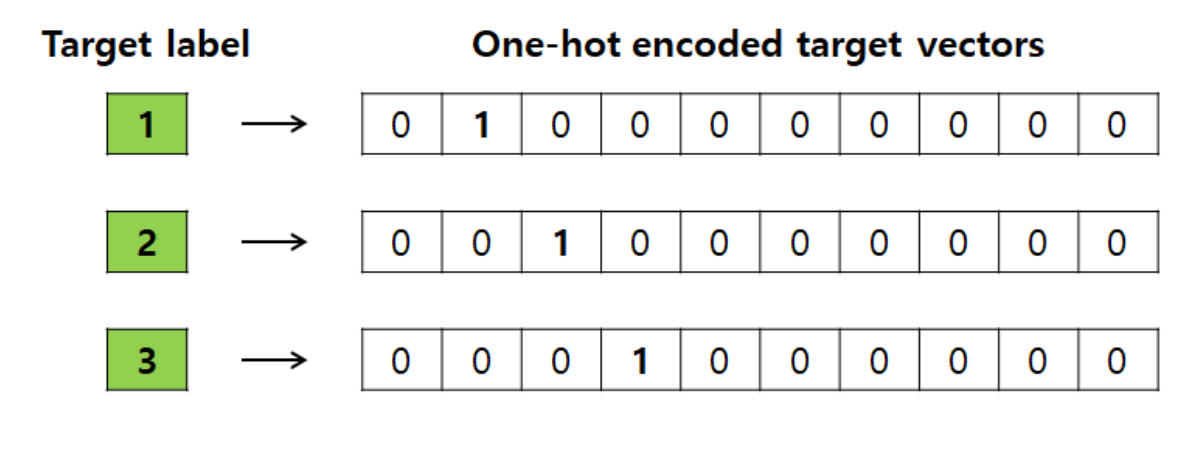

In [8]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_test.shape[1]

In [10]:
# TensorBoard
# small 'b' 사용시 오류날 경우 대문자'B'로 수정
## --> from tensorflow.keras.callbacks import Tensorboard
from tensorflow.keras.callbacks import TensorBoard

## 2. Create the Model
##### 입력 텐서 크기를 설정
- input_shape = (image_height, image_width, image_channels) = (28, 28, 1)

##### 간단한 CNN 모델 구성
- input 레이어 (Convolution 레이어) --> 맥스 풀링 --> Flatten --> Dense 층 --> Output 레이어 (soft-max)

In [11]:
#from keras.models import Sequential
#from keras.layers import Convolution2D # from keras.layers import Conv2D
# from keras import models
# from keras import layers
#from keras.layers import Conv2D
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import pickle
import numpy as np
import os
import time

def convolutional_model():   
    # create model
    model = Sequential()
    model.add(Conv2D(16, (5, 5), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [12]:
# model.summary() 함수를 이용해 전체 모델 구조 확인
model = convolutional_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               230500    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 231,926
Trainable params: 231,926
Non-trainable params: 0
_________________________________________________________________


## 3. Compile the Model
- 모델 훈련 전 model.sompile() 함수를 통해 훈련 환경을 설정
- 옵티마이저는 'adam' 사용
- 분류 모델에서 loss는 'categorical crossentropy' 값으로 지정해주고, metrics는 정확도를 나타내는 'accuracy' 입력하기

##### 손실 함수 (Loss function)
- 손실함수는 실제값과 예측값의 차이를 수치화해주는 함수이다. 즉, 오차가 클수록 손실함수의 값은 크고 오차가 작을수록 손실함수의 값은 작아진다. 회귀에서는 평균제곱오차, 분류문제에서는 크로스 엔트로피를 주로 손실함수로 사용한다. 손실함수의 값을 최소화하는 두개의 매개변수인 가중치 W와 편향 b를 찾아가는 것이 딥러닝의 학습과정이므로, 손실함수의 선정을 매우 중요하다.

###### 손실함수의 "크로스 엔트로피(Cross-Entropy)"
- 낮은 확률로 예측해서 맞추거나, 높은 확률로 예측해서 틀리는 경우 loss가 더 크다.
- keras의 model.compile()에서는 Binary Classification과 Multi-Class Classification을 사용한다.

- a. 이진분류(Binary Classification)의 경우, binary_crossentropy를 사용한다.
- ex. model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
- b. 다중 클래스 분류(Multi-Class Classification)일 경우 categorical_crossentropy를 사용한다.
- ex. model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

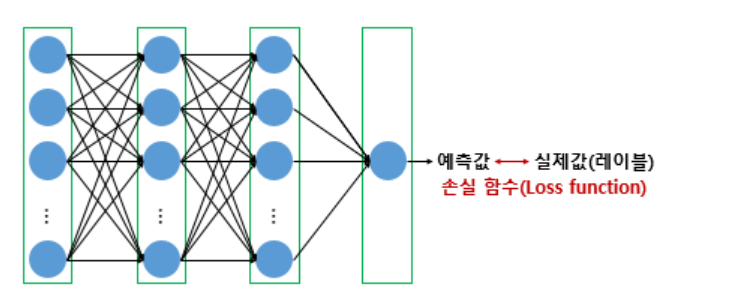

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

> optimizer='adam',
- 아담은 알엠에스프롭과 모멘텀 두 가지를 합친 듯한 방법으로, 방향과 학습률 두 가지를 모두 잡기 위한 방법

> 그외, 옵티마이저는 아담을 포함하여 7가지가 있는데, 참고할 사이트는 아래와 같음
- https://wikidocs.net/36033

## 4. Train the Model
- model.fit() 함수를 이용해 모델을 훈련시키기

In [15]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

Epoch 1/10
300/300 - 6s - loss: 0.3115 - accuracy: 0.9146 - val_loss: 0.1135 - val_accuracy: 0.9681
Epoch 2/10
300/300 - 6s - loss: 0.0925 - accuracy: 0.9730 - val_loss: 0.0642 - val_accuracy: 0.9795
Epoch 3/10
300/300 - 6s - loss: 0.0610 - accuracy: 0.9825 - val_loss: 0.0529 - val_accuracy: 0.9827
Epoch 4/10
300/300 - 6s - loss: 0.0478 - accuracy: 0.9856 - val_loss: 0.0443 - val_accuracy: 0.9843
Epoch 5/10
300/300 - 6s - loss: 0.0385 - accuracy: 0.9884 - val_loss: 0.0410 - val_accuracy: 0.9864
Epoch 6/10
300/300 - 7s - loss: 0.0327 - accuracy: 0.9902 - val_loss: 0.0397 - val_accuracy: 0.9868
Epoch 7/10
300/300 - 7s - loss: 0.0268 - accuracy: 0.9919 - val_loss: 0.0403 - val_accuracy: 0.9861
Epoch 8/10
300/300 - 7s - loss: 0.0228 - accuracy: 0.9930 - val_loss: 0.0383 - val_accuracy: 0.9870
Epoch 9/10
300/300 - 8s - loss: 0.0197 - accuracy: 0.9945 - val_loss: 0.0445 - val_accuracy: 0.9857
Epoch 10/10
300/300 - 7s - loss: 0.0164 - accuracy: 0.9950 - val_loss: 0.0402 - val_accuracy: 0.9865

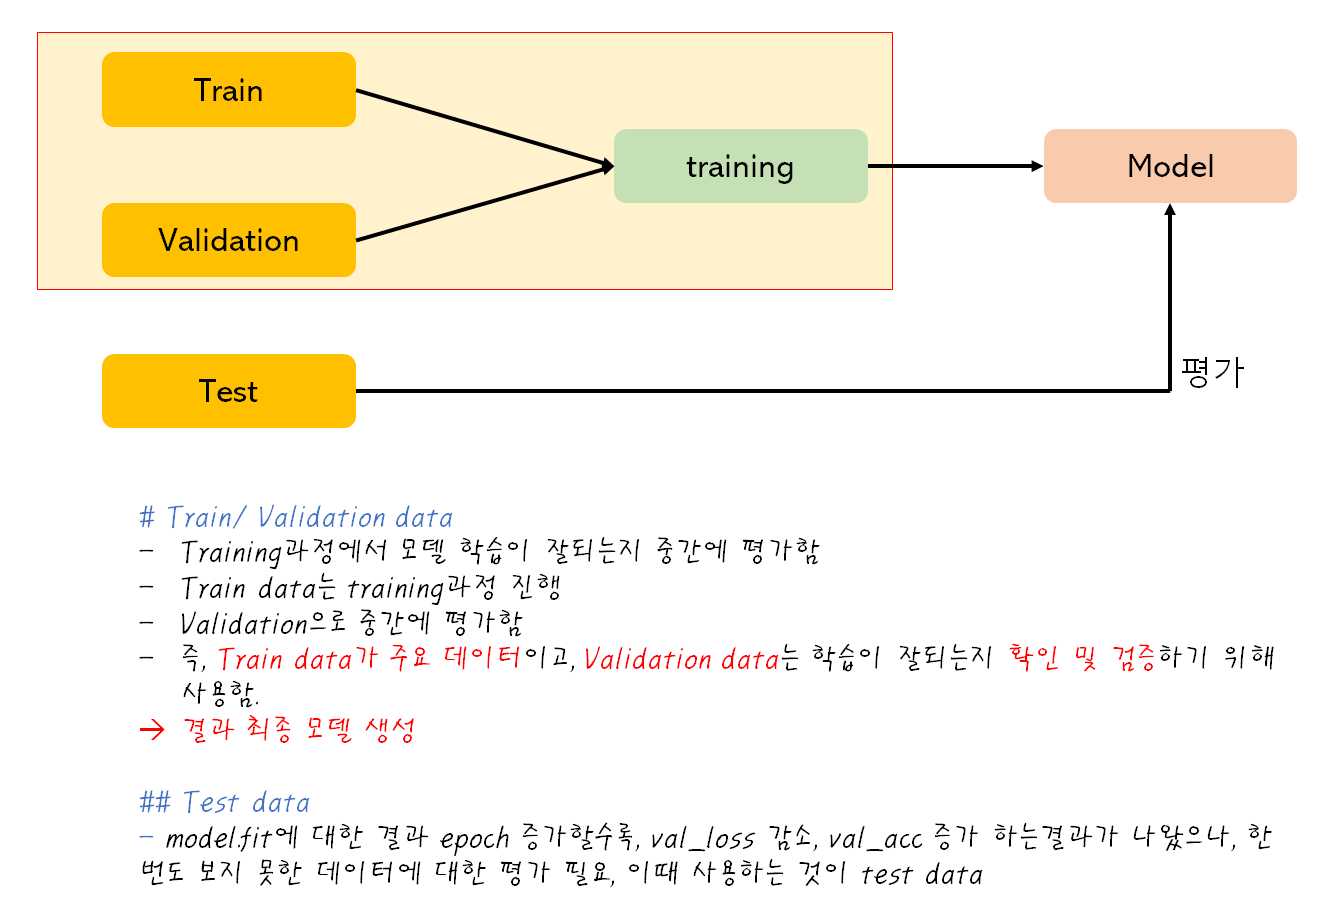

## 5. Evaluate the Model 
- model.evaluate() 함수를 이용해 모델 성능을 평가하기

In [16]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

Accuracy: 0.9865000247955322 
 Error: 1.3499975204467773
